# Debugging the Cached Inception Transfer Learning

## 1. Generating the Transfer Values

In [14]:
import tensorflow as tf
import model.inception_v3 as inception_v3
import data.tiny_imagenet as data
import pickle 
import numpy as np
import os
import sys

slim = tf.contrib.slim

ACTIVATION_DIM = 2048

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from datetime import timedelta

In [44]:
##################### Tiny ImageNet Loading Helper ######################
import cv2

# Helper Functions to load all the images, not create a `tf.train.input_producer`-queue
def load_image(filename):
    img = cv2.imread(filename)
    return img

def load_tiny_image_net(mode, labels_only=False, limit=None):
    filenames_labels = data.load_filenames_labels(mode)
    labels = np.array([label for _, label in filenames_labels])
    labels = labels.astype(np.uint8)
    filenames = np.array([filename for filename, _ in filenames_labels])
    
    np.random.seed(1234)
    idx = np.random.permutation(len(filenames_labels))
    labels = labels[idx]
    filenames = filenames[idx]
    
    if limit:
        labels = labels[:limit]
        filenames = filenames[:limit]
        
    if labels_only:
        return [], labels 
    else:
        images = np.array([load_image(f) for f in filenames])
    return images, labels
#########################################################################

### Helper Method to Show Images (Sanity Checking)

In [68]:
_, class_description = tiny_imagenet.build_label_dicts()

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    hspace = 2
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_description[cls_true[i]].split(", ")[0]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Constructing the Model

In [65]:
def inception_v3_features(images):
    with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
        _, endpoints = inception_v3.inception_v3(
            inputs=images,
            num_classes=1001,
            is_training=False,
            dropout_keep_prob=1,
            create_aux_logits=False)
    features = endpoints['PreLogits']   # Nx1x1xACTIVATION_DIM
    return features

In [176]:
def inference_in_batches(all_images, batch_size):
    """Returns a numpy array of the activations of shape len(all_images)x2048
    - all_images: 4d numpy array of shape Nx(data.IMG_DIM)x(data.IMG_DIM)x(data.IMG_CHANNELS)
    """
    graph = tf.Graph()
    with graph.as_default():
        batch_placeholder = tf.placeholder(tf.float32, shape=[None, data.IMG_DIM, data.IMG_DIM, data.IMG_CHANNELS])
        scaled_batch = tf.image.resize_images(images=batch_placeholder, size=[299, 299])
        scaled_batch = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), scaled_batch)
        activations = inception_v3_features(scaled_batch)

        init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        saver = inception_v3.create_saver()

    sess = tf.Session(graph=graph)
    num_images = len(all_images)
    result = np.ndarray(shape=(num_images, ACTIVATION_DIM))
    scaled_images = np.ndarray(shape=(num_images, 299, 299, 3))
    
    with sess.as_default():
        sess.run(init)
        inception_v3.restore(sess, saver)

        full_batches = num_images // batch_size
        num_batches = full_batches if num_images % batch_size == 0 else full_batches + 1
        
        print("Running %d batches of activations" % (num_batches))

        for i in range(num_batches):
            msg = "\r- Processing batch: {0:>6} / {1}".format(i+1, num_batches)
            sys.stdout.write(msg)
            sys.stdout.flush()

            from_idx = i*batch_size
            to_idx = min((i+1)*batch_size, num_images)
            batch_values = all_images[from_idx:to_idx]
            batch_result, scaled_batch_vals = sess.run([activations, scaled_batch], feed_dict={
                batch_placeholder: batch_values
            })

            result[from_idx:to_idx] = np.squeeze(batch_result)  # remove 1x dimensions
            scaled_images[from_idx:to_idx] = scaled_batch_vals
        print("") # new line

    return result, scaled_images


def activations_are_cached(cache_path):
    return os.path.exists(cache_path)

def read_cache_or_generate_activations(cache_path, all_images, batch_size=64):
    # If the cache-file exists
    if activations_are_cached(cache_path):
        # Load the cached data from the file
        with open(cache_path, mode='rb') as file:
            activations = pickle.load(file)
            scaled_images = []
        print("- Activations loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.
        # Generate activations
        activations, scaled_images = inference_in_batches(all_images, batch_size=batch_size)

        # Save the data to a cache-file.
        with open(cache_path, mode='wb') as file:
            pickle.dump(activations, file)
        print("- Activations saved to cache-file: " + cache_path)
    return activations, scaled_images


CACHE_DIR = os.path.expanduser("~/.models/cached_activations/")

def get_cache_path(mode):
    return os.path.join(CACHE_DIR, "tiny_imagenet_" + mode + ".pkl")

## 2. Load Tiny ImageNet

In [167]:
limit = 100
mode = 'train'
train_images, train_labels = load_tiny_image_net(mode=mode, limit=limit)

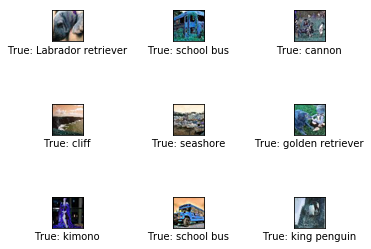

In [168]:
plot_images(train_images[:9], train_labels[:9])

In [178]:
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
activations, scaled_images = read_cache_or_generate_activations(cache_path=cache.get_cache_path(mode),
                                                                all_images=train_images,
                                                                batch_size=100)

INFO:tensorflow:Restoring parameters from /Users/fp/.models/inception_v3.ckpt
Running 1 batches of activations
- Processing batch:      1 / 1
- Activations saved to cache-file: /Users/fp/.models/cached_activations/tiny_imagenet_train.pkl


In [179]:
scaled_images = scaled_images.astype(np.uint8)
activations.shape, scaled_images.shape

((100, 2048), (100, 299, 299, 3))

small: 


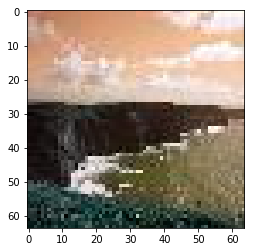

In [171]:
i = 3
print("small: ")
plt.imshow(train_images[i], interpolation='nearest')

big: 


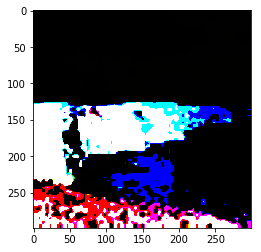

In [172]:
print("big: ")
plt.imshow(scaled_images[i], interpolation='nearest')

### Helper Functions for Plotting the Transfer Values

In [173]:
def plot_transfer_values(transfer_val, image=None):
    if image is not None:
        print("Input image:")

        # Plot the i'th image from the test-set.
        plt.imshow(image, interpolation='nearest')
        plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_val
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


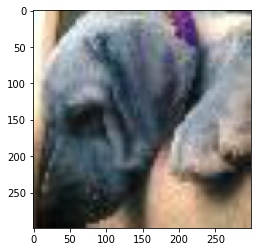

Transfer-values for the image using Inception model:


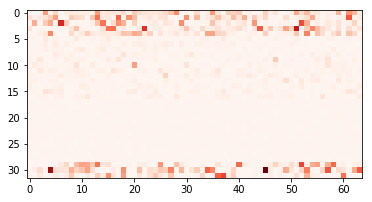

In [180]:
plot_transfer_values(activations[0], scaled_images[0])

Transfer-values for the image using Inception model:


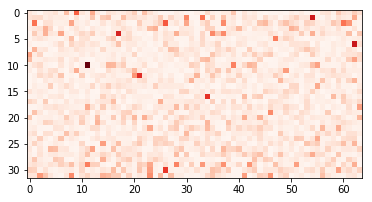

In [175]:
diff = abs(activations[41]-activations[40])
plot_transfer_values(diff)

In [117]:
a = activations[5]
print("mean a: \t\t", np.mean(a))
print("mean a 1400:1600\t", np.mean(a[1400:1600]))

mean a: 		 6.996730076678773
mean a 1400:1600	 1.392834865152836
